In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from schwrz_lens_v2 import *
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as colors

eps = np.finfo(float).eps 

%load_ext autoreload
%autoreload 2

%matplotlib notebook

In [2]:
# Dynamic spectrum from physical parameters
M = 5*u.earthMass
D = 1*u.kpc
mu_rel = 1*u.mas/u.yr
y0 = 0.5
t0 = 0*u.s

nu_GHz_max = 20
tau_width = 30
Nv = 600
Nt = 600

nu_half = np.arange(0, nu_GHz_max, nu_GHz_max/Nv)*u.GHz
thE = theta_E(M, D)
tE = get_tE(mu_rel, thE)

taus = np.linspace(-tau_width/2, tau_width/2, Nt)
ts = taus*tE+t0

In [3]:
plt.style.use('/home/calvin/wave_optics_review/text/plot_scripts/paper_sty.mplstyle')

In [4]:
# Compute dynamic spectrum for positive frequencies
mus0 = get_lightcurve_obvs(ts, nu_half, M, tE, y0, regime='wave')       
mus_eik0 = get_lightcurve_obvs(ts, nu_half, M, tE, y0, regime='eikonal')

# Create symmetric array with negative frequencies
mus = np.append(np.flip(mus0)[:-1,:], mus0[:-1,:], axis=0)
mus_eik = np.append(np.flip(mus_eik0)[:-1,:], mus_eik0[:-1,:], axis=0)
diff = (mus - mus_eik)/mus

nus = np.append(np.flip(-nu_half.value)[:-1], (nu_half.value)[:-1])*u.GHz

In [5]:
# Compute FT along frequency axis
ftw = np.array([np.fft.fftshift(np.fft.fft(mw)) for mw in mus.T]).T
ftw_diff = np.array([np.fft.fftshift(np.fft.fft(mw)) for mw in diff.T]).T
fw = np.fft.fftshift(np.fft.fftfreq(len(nus), abs(nus[-1]-nus[0])/len(nus)))*u.ns

ftwpow = np.abs(ftw)**2/np.max(ftw)**2

# remove alternating sign artefact in ftw_diff
fsign = 2*(np.arange(ftw_diff.shape[0])%2)-1
ftw_diff = ftw_diff*fsign[:,None]

In [11]:
journal_textwidths = {'prd': 6.50127,
                   'none': 8.5,
                   'kaobook':6.5, # just a guess
                   'issi':7.5 # just a guess
                   } # Latex's \textwidth in inches

def figsize(fraction_of_textwidth = 0.45,height_per_width  = 1 / 1.61803399,journal = 'prd'):
     textwidth = journal_textwidths[journal]
     width_in = textwidth * fraction_of_textwidth
     height_in = height_per_width * width_in
     return (width_in, height_in)


In [23]:
np.sqrt(2.87459975e-21)

5.3615293993411993e-11

In [62]:
def y_to_t(y):
    y0 = 0.5
    th_E = 5.3615293993411993e-11 #np.sqrt(2.87459975e-21) # radians 4*G*(5 earth mass) / (1 kpc * c^2)
    mu_E = 1.328e-11 # 1 mas /year in paper; we want units of radians days^-1.
    return np.sqrt(np.abs(y**2 - y0**2)) * th_E / mu_E #radians days-1

def t_to_y(t):
    y0 = 0.5
    th_E = 5.3615293993411993e-11 #np.sqrt(2.87459975e-21) # radians 4*G*(5 earth mass) / (1 kpc * c^2)
    mu_E = 1.328e-11
    
    return (1.0*(t >= 0) - 1.0*(t < 0)) * ((t * mu_E / th_E)**2 + y0**2)**0.5

def omega_to_Omega(omega):
    # Omega = 4*G*(5 earth mass)*(omega / 1 GHz) / c^3 = 0.295874288
    return omega * 0.295874288


def Omega_to_omega(O):
    return O / 0.295874288

<IPython.core.display.Javascript object>


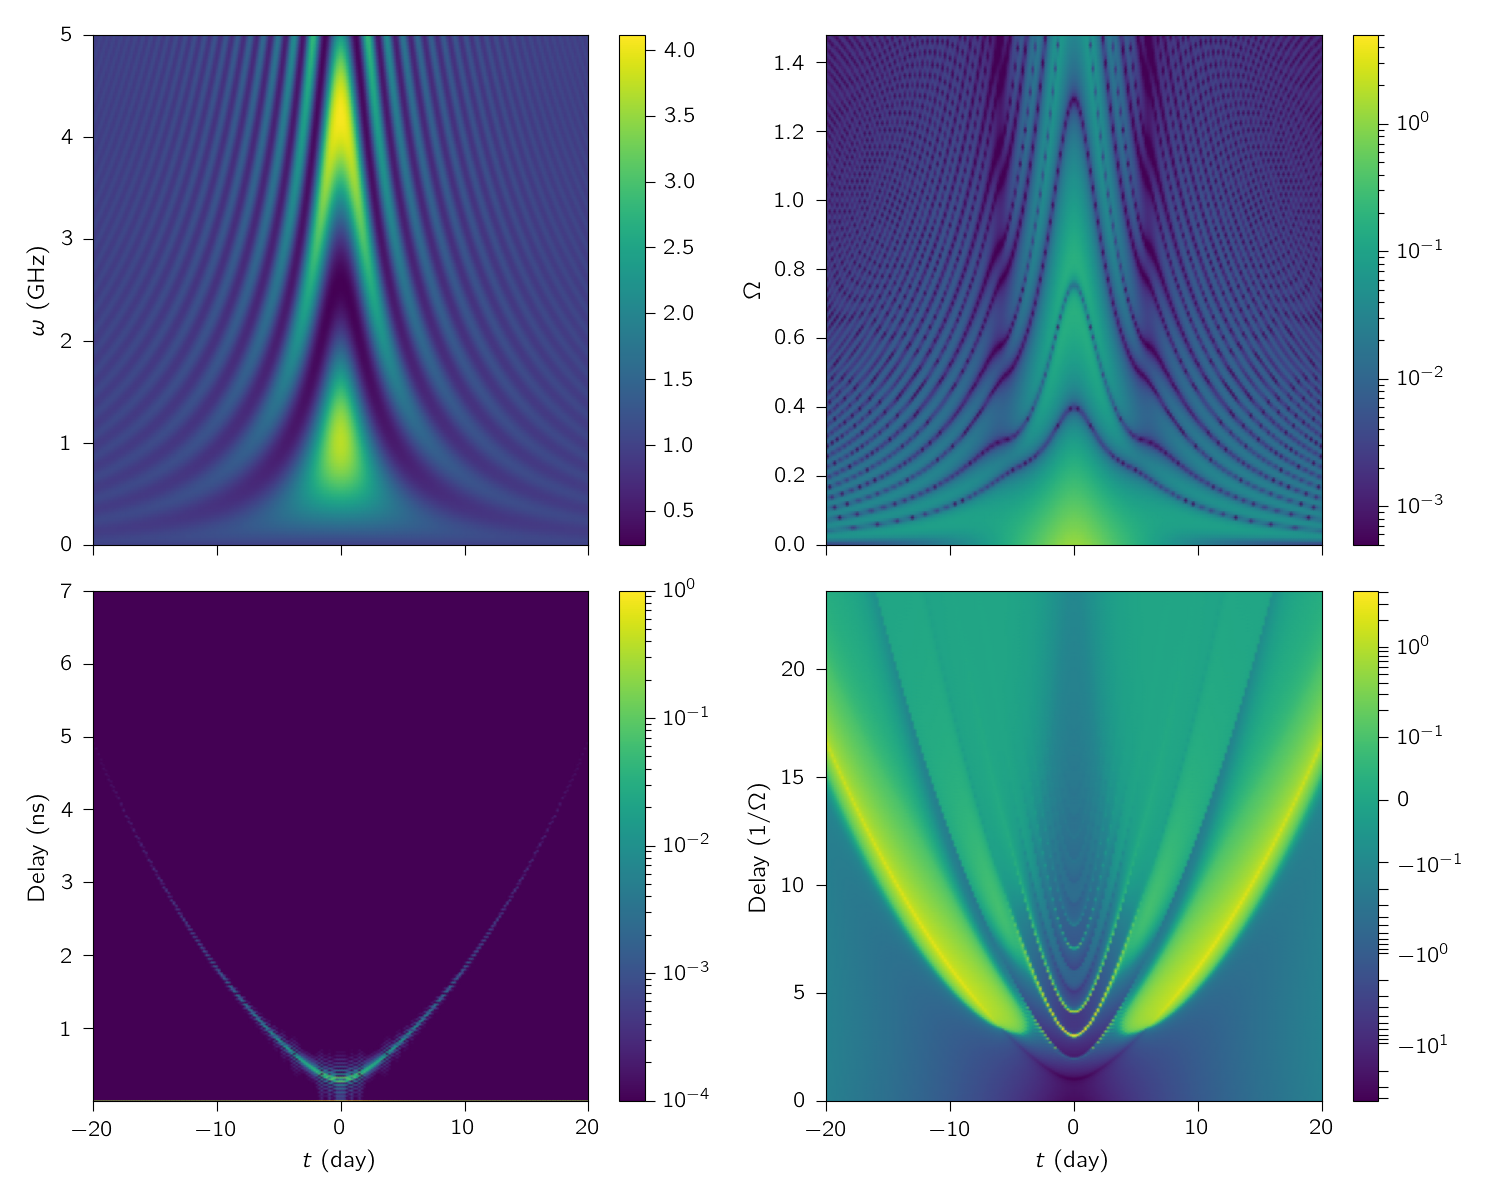

/home/calvin/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


In [67]:
fig, ((ax, ax1),(ax2,ax3)) = plt.subplots(2,2, 
                                          figsize=figsize(fraction_of_textwidth=1,height_per_width=.8,journal='issi'),
                                          sharex=True,
                                         )
ax.set_xlim(-20, 20)
ax.set_ylim(0, 5)
#ax.set_xlabel('$t$ (day)', fontsize=18)
ax.set_ylabel('$\\omega$ (GHz)')
ax.tick_params(axis='both', which='major')
im = ax.pcolormesh((ts.to(u.d)).value, nus.value, mus, shading='gouraud', rasterized=True)




#secaxx = ax.secondary_xaxis('top', functions=(t_to_y, y_to_t))
#secaxx.set_xlabel('$y$')

#cbaxes = fig.add_axes([0.5, 0.5, 0.02, 0.5]) 
 
# position for the colorbar
#cbar.ax.tick_params(labelsize=14)
cb = plt.colorbar(im, ax = ax)

plt.show()


ax1.set_xlim(-20, 20)
ax1.set_ylim(0, omega_to_Omega(5))
#ax1.yaxis.tick_right()
#secaxy = ax1.secondary_yaxis('right', functions=(omega_to_Omega, Omega_to_omega))
ax1.set_ylabel('$\\Omega$')
#ax1.set_xlabel('$t$ (day)', fontsize=18)
#ax1.set_ylabel('$\\omega$ (GHz)', fontsize=18)
ax1.tick_params(axis='both', which='major')
im1 = ax1.pcolormesh((ts.to(u.d)).value, omega_to_Omega(nus.value), np.abs(diff),
                     norm=colors.LogNorm(vmin=5e-4, vmax=5), shading='gouraud', rasterized=True)
cbar1 = plt.colorbar(im1, ax=ax1)
#cbar1.ax.tick_params(labelsize=14)
#plt.tight_layout()

ax2.set_xlim(-20, 20)
ax2.set_ylim(0.01, 7)
ax2.set_xlabel('$t$ (day)')
ax2.set_ylabel('Delay (ns)')
ax2.tick_params(axis='both', which='major')
im2 = ax2.pcolormesh((ts.to(u.d)).value, fw.value, np.abs(ftwpow), 
                     norm=colors.LogNorm(vmin=1e-4), shading='gouraud', rasterized=True)
cbar2 = plt.colorbar(im2, ax=ax2)
#cbar2.set_label('power, arbitrary')
#cbar2.ax.tick_params(labelsize=14)

ax3.set_xlim(-20, 20)
ax3.set_ylim(0, 7/ 0.295874288)
ax3.set_xlabel('$t$ (day)')
ax3.set_ylabel('Delay (1/$\\Omega$)')
ax3.tick_params(axis='both', which='major')
im3 = ax3.pcolormesh((ts.to(u.d)).value, fw.value / 0.295874288 , np.real(ftw_diff),
                     norm=colors.SymLogNorm(1e-1), shading='gouraud', rasterized=True)
cbar3 = plt.colorbar(im3, ax=ax3)
#cbar3.set_label('power, arbitrary', fontsize=14)
#cbar3.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

fig.savefig('/home/calvin/wave_optics_review/text/figs/jow_2020_fig3.pdf', bbox_inches='tight', dpi=300)

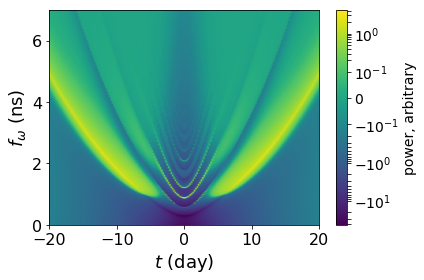

In [6]:
# plot FT of difference
fig, ax = plt.subplots()

ax.set_xlim(-20, 20)
ax.set_ylim(0, 7)
ax.set_xlabel('$t$ (day)', fontsize=18)
ax.set_ylabel('$f_\\omega$ (ns)', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
im = ax.pcolormesh((ts.to(u.d)).value, fw.value, np.real(ftw_diff),norm=colors.SymLogNorm(1e-1), shading='gouraud', rasterized=True)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('power, arbitrary', fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

fig.savefig('diff_ft1.pdf', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


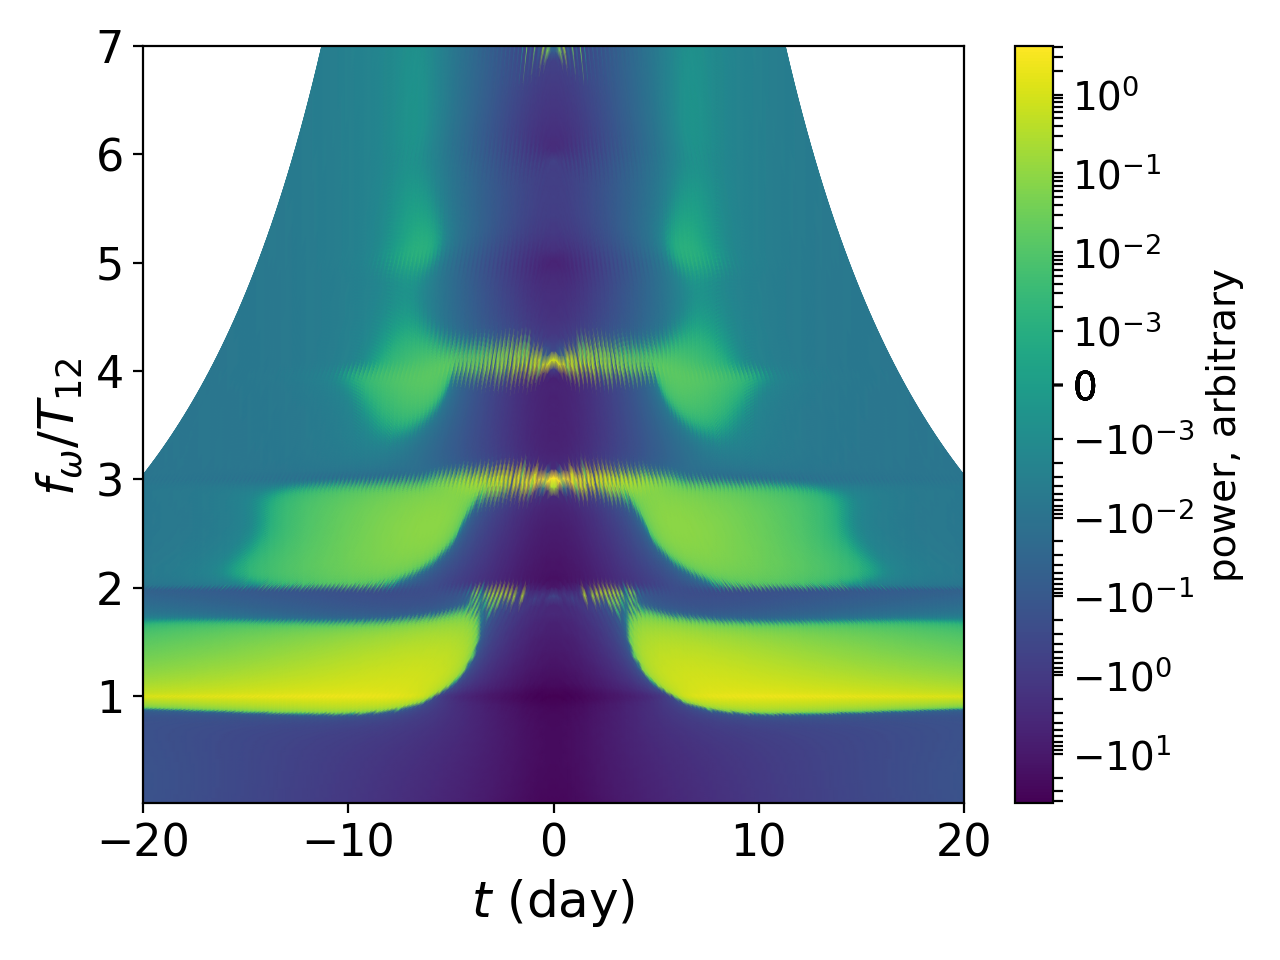

In [48]:
# plot FT of difference with coords rescaled
tmesh, fwmesh = np.meshgrid(ts.to(u.d), fw)
taumesh = ((tmesh-t0)/tE).decompose()
ymesh = rect_y(taumesh, y0)
Tmesh = (4*G*M*T12(ymesh)/c**3).decompose()
zmesh = (fwmesh/Tmesh).decompose()

fig, ax = plt.subplots()
ax.set_xlim(-20, 20)
ax.set_ylim(0.01, 7)
ax.set_xlabel('$t$ (day)', fontsize=18)
ax.set_ylabel('$f_\\omega / T_{12}$ ', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
im = ax.pcolormesh(tmesh.value, zmesh.value, ftw_diff.real, norm=colors.SymLogNorm(1e-3), shading='gouraud', rasterized=True)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('power, arbitrary', fontsize=14)
cbar.ax.tick_params(labelsize=14)
plt.tight_layout()
plt.show()


In [39]:
np.min(abs(ftw_diff.real))

2.7529038253134926e-07

In [7]:
from mpmath import hyp1f1


In [ ]:
wave_totmag()

In [9]:
si = np.linspace(0,10)
y = np.linspace(0,10,num=11)
S,Y = np.meshgrid(si,y)

In [ ]:
def wave_totmag(y, s):
    s = np.abs(s)
    if np.abs(s) < 1e-10:
        pref = 1.
    else:
        pref = np.pi*s/(1 - np.exp(-np.pi*s))
        
    if hasattr(s, '__len__') and not hasattr(y, '__len__'):
        hpg = [abs(complex(hyp1f1(complex(0.5*1j*si), 1, complex(0.5*1j*si*y**2))))**2 for si in s]
    elif not hasattr(s, '__len__') and hasattr(y, '__len__'):
        hpg = [abs(complex(hyp1f1(complex(0.5*1j*s), 1, complex(0.5*1j*s*yi**2))))**2 for yi in y]
    elif hasattr(s, '__len__') and hasattr(y, '__len__'):
        if len(y) != len(s):
            print('Input parameters y and s must have same length, or one must have length 1.')
        else:
            hpg = [abs(complex(hyp1f1(complex(0.5*1j*si), 1, complex(0.5*1j*si*yi**2))))**2 for (si, yi) in zip(s, y)]
    else:
        hpg = abs(complex(hyp1f1(complex(0.5*1j*s), 1, complex(0.5*1j*s*y**2))))**2
    hpg = np.array(hpg)
    return pref*hpg
